<a href="https://colab.research.google.com/github/haruki0556/Chest_MRI/blob/main/Covid_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# 必要ライブラリ・コマンドの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1
w = !apt install tree
print(w[-2])

Setting up tree (2.0.2-1) ...


In [5]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

In [6]:
# PyTorch関連ライブラリのインポート

import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

In [7]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [8]:
# GPUチェック

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### 共通関数の読み込み

In [9]:
# 共通関数のダウンロード
!git clone https://github.com/haruki0556/Chest_MRI.git

# 共通関数のロード
from Chest_MRI.common_function.utils import *

# 共通関数の存在チェック
print(README)

Cloning into 'Chest_MRI'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 35 (delta 8), reused 24 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 2.39 MiB | 29.85 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Hello!Haruki!


### サンプルデータのダウンロード・解凍

In [10]:
from google.colab import files
files.upload()

Saving Covid.zip to Covid.zip


In [11]:
# データ解凍
w = !unzip -o Covid.zip

# 結果確認
print(w[-1])

  inflating: Covid19-dataset/train/Viral Pneumonia/096.jpeg  


In [13]:
!ls

Chest_MRI  Covid19-dataset  Covid.zip  sample_data


In [15]:
import os

In [16]:
# =================================================================
# 3. ディレクトリ名 リネーム処理
# =================================================================

# ❗重要❗
# ZIP解凍後、クラス名フォルダ（例: cat, dog）が格納されている親ディレクトリのパスを設定してください。
# 例1: 解凍後 -> /extracted_dataset/cat, /extracted_dataset/dog の場合
data_root_dir1 = './Covid19-dataset/train'
data_root_dir2 = './Covid19-dataset/test'
# 例2: 解凍後 -> /extracted_dataset/images/cat, /extracted_dataset/images/dog の場合
# data_root_dir = './extracted_dataset/images/'

# リネームしたいクラス名の対応表
# キーが「現在のフォルダ名」、値が「新しいフォルダ名」です
rename_map = {
    'Covid': 'COV',
    'Normal': 'NML',
    'Viral Pneumonia':'VPNA'
    # 実際にご自身のデータに合わせて追記・修正してください
}
# =================================================================

print("\n--- ディレクトリ名 変更開始 ---")

for old_name, new_name in rename_map.items():
    old_path = os.path.join(data_root_dir1, old_name)
    new_path = os.path.join(data_root_dir1, new_name)

    # 変更元のフォルダが存在するかチェック
    if os.path.isdir(old_path):
        try:
            # os.rename() でフォルダ名を変更
            os.rename(old_path, new_path)
            print(f"✅ 成功: '{old_name}' -> '{new_name}'")
        except Exception as e:
            print(f"❌ エラー: '{old_name}' のリネーム中にエラーが発生しました: {e}")
    else:
        print(f"⚠️ スキップ: '{old_name}' というディレクトリは '{data_root_dir}' に存在しません。")

print("--- ディレクトリ名 変更完了 ---")

# =================================================================
# 4. 変更後のディレクトリ構造を再確認
# =================================================================
print("\n--- 変更後のディレクトリ構造 ---")
!ls -F {data_root_dir1}


--- ディレクトリ名 変更開始 ---
✅ 成功: 'Covid' -> 'COV'
✅ 成功: 'Normal' -> 'NML'
✅ 成功: 'Viral Pneumonia' -> 'VPNA'
--- ディレクトリ名 変更完了 ---

--- 変更後のディレクトリ構造 ---
COV/  NML/  VPNA/


In [17]:
print("\n--- ディレクトリ名 変更開始 ---")

for old_name, new_name in rename_map.items():
    old_path = os.path.join(data_root_dir2, old_name)
    new_path = os.path.join(data_root_dir2, new_name)

    # 変更元のフォルダが存在するかチェック
    if os.path.isdir(old_path):
        try:
            # os.rename() でフォルダ名を変更
            os.rename(old_path, new_path)
            print(f"✅ 成功: '{old_name}' -> '{new_name}'")
        except Exception as e:
            print(f"❌ エラー: '{old_name}' のリネーム中にエラーが発生しました: {e}")
    else:
        print(f"⚠️ スキップ: '{old_name}' というディレクトリは '{data_root_dir}' に存在しません。")

print("--- ディレクトリ名 変更完了 ---")

# =================================================================
# 4. 変更後のディレクトリ構造を再確認
# =================================================================
print("\n--- 変更後のディレクトリ構造 ---")
!ls -F {data_root_dir2}


--- ディレクトリ名 変更開始 ---
✅ 成功: 'Covid' -> 'COV'
✅ 成功: 'Normal' -> 'NML'
✅ 成功: 'Viral Pneumonia' -> 'VPNA'
--- ディレクトリ名 変更完了 ---

--- 変更後のディレクトリ構造 ---
COV/  NML/  VPNA/


In [18]:
# 解凍ファイルのtree表示
!tree Covid19-dataset

Covid19-dataset
├── test
│   ├── COV
│   │   ├── 0100.jpeg
│   │   ├── 0102.jpeg
│   │   ├── 0105.png
│   │   ├── 0106.jpeg
│   │   ├── 0108.jpeg
│   │   ├── 0111.jpg
│   │   ├── 0112.jpg
│   │   ├── 0113.jpg
│   │   ├── 0115.jpeg
│   │   ├── 0118.jpeg
│   │   ├── 0119.jpeg
│   │   ├── 0120.jpg
│   │   ├── 094.png
│   │   ├── 096.png
│   │   ├── 098.jpeg
│   │   ├── auntminnie-2020_01_31_20_24_2322_2020_01_31_x-ray_coronavirus_US.jpg
│   │   ├── auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
│   │   ├── auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
│   │   ├── auntminnie-c-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
│   │   ├── auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
│   │   ├── COVID-00003b.jpg
│   │   ├── COVID-00012.jpg
│   │   ├── COVID-00022.jpg
│   │   ├── COVID-00033.jpg
│   │   ├── COVID-00037.jpg
│   │   └── radiopaedia-2019-novel-coronavirus-infected-pneumonia.jpg
│   ├── NML
│   │  

### Transforms定義

In [19]:
# Transforms定義

# 検証データ用 : 正規化のみ実施
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# 訓練データ用: 正規化に追加で反転とRandomErasingを実施
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

### データセット定義

In [20]:
# ツリーのベースディレクトリ
data_dir = 'Covid19-dataset'

# 訓練データディレクトリと検証データディレクトリの指定
import os
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# join関数の結果確認
print(train_dir, test_dir)

# 分類先クラスのリスト作成
classes = ['COV', 'NML','VPNA']

Covid19-dataset/train Covid19-dataset/test


In [21]:
# データセット定義

# 訓練用
train_data = datasets.ImageFolder(train_dir,
            transform=train_transform)
# 訓練データのイメージ表示用
train_data2 = datasets.ImageFolder(train_dir,
            transform=test_transform)
# 検証用
test_data = datasets.ImageFolder(test_dir,
            transform=test_transform)

In [22]:
# データ件数確認

print(f'訓練データ: {len(train_data)}件')
print(f'検証データ: {len(test_data)}件')

訓練データ: 251件
検証データ: 66件


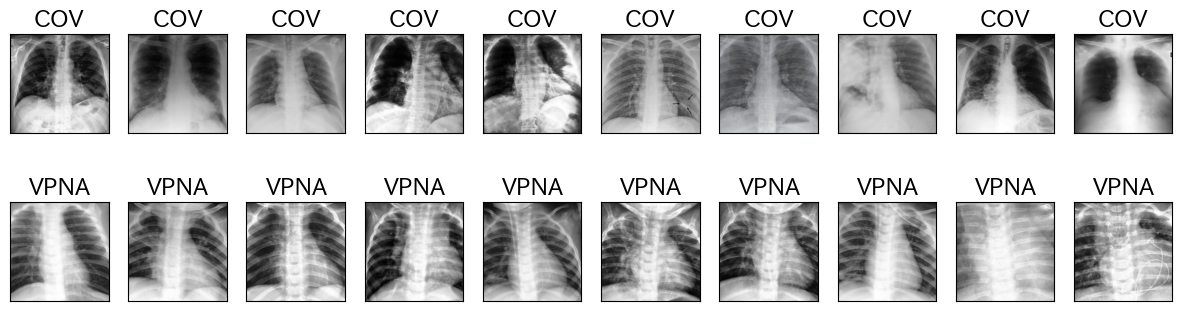

In [23]:
# 検証データ
# 最初の10個と最後の10個の表示

plt.figure(figsize=(15, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    image, label = test_data[i]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 10, i + 11)
    image, label = test_data[-i-1]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### データローダー定義

In [24]:
# データローダー定義

batch_size = 50

# 訓練用
train_loader = DataLoader(train_data,
      batch_size=batch_size, shuffle=True)

# 検証用
test_loader = DataLoader(test_data,
      batch_size=batch_size, shuffle=False)

# イメージ表示用
train_loader2 = DataLoader(train_data2,
      batch_size=50, shuffle=True)
test_loader2 = DataLoader(test_data,
      batch_size=50, shuffle=True)

### イメージ表示

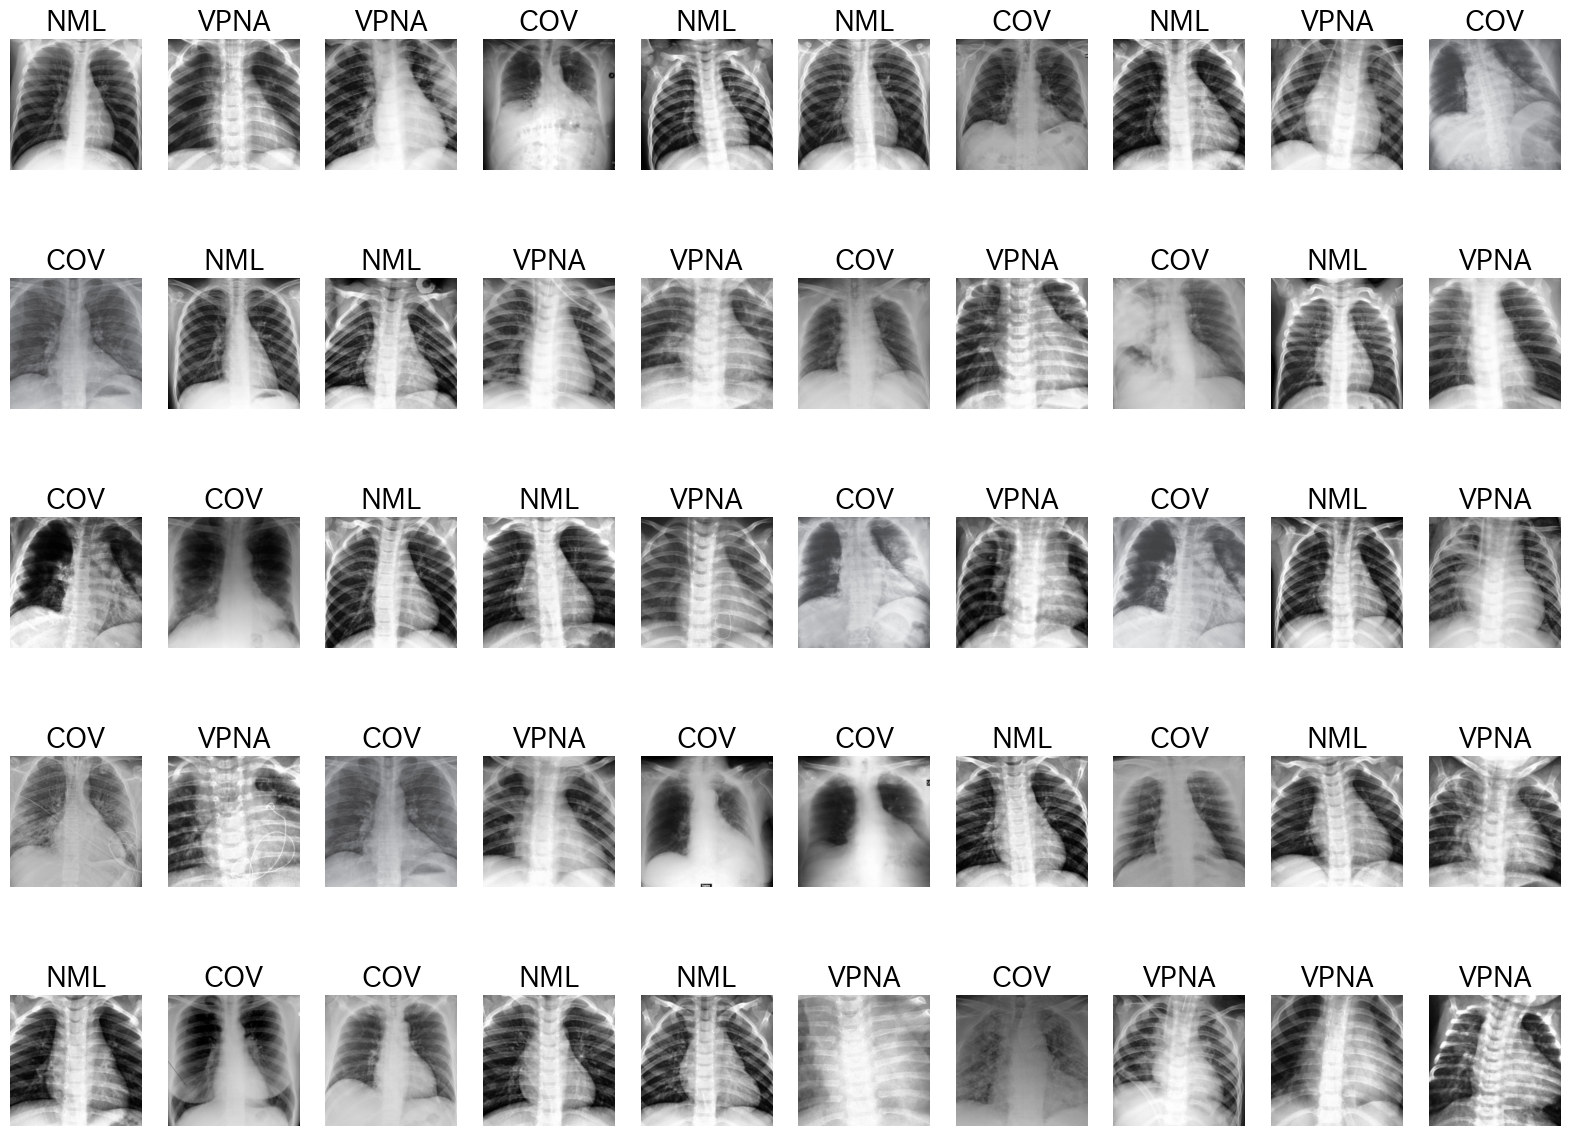

In [25]:
# 検証用データ(50件)
torch_seed()
show_images_labels(test_loader2, classes, None, None)

## ファインチューニング版

In [30]:
# ファインチューニング版

# 学習済みモデルの読み込み
# vgg19_bnをパラメータ付きで読み込む
from torchvision import models
net = models.vgg19_bn(pretrained = True)

# 乱数初期化
torch_seed()

# 最終ノードの出力を2に変更する
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 3)

# AdaptiveAvgPool2d関数の取り外し
net.avgpool = nn.Identity()

# GPUの利用
net = net.to(device)

# 学習率
lr = 0.001

# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
optimizer = optim.SGD(net.parameters(),lr=lr,momentum=0.9)

# historyファイルも同時に初期化する
history = np.zeros((0, 5))

In [31]:
# 学習
num_epochs = 20
history = fit(net, optimizer, criterion, num_epochs,
          train_loader, test_loader, device, history)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[1/20],loss:1.11010 acc:0.36255 test_loss:1.0319754174261382 test_acc:0.40909


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[2/20],loss:1.08438 acc:0.43825 test_loss:0.9482086156353806 test_acc:0.60606


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[3/20],loss:0.93963 acc:0.54980 test_loss:1.095599479747541 test_acc:0.33333


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[4/20],loss:1.01153 acc:0.40637 test_loss:0.7635443066105698 test_acc:0.69697


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[5/20],loss:0.78242 acc:0.67729 test_loss:0.6461019985603563 test_acc:0.66667


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[6/20],loss:0.66080 acc:0.69323 test_loss:0.5122451709978508 test_acc:0.74242


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[7/20],loss:0.53011 acc:0.81673 test_loss:0.4216304800727151 test_acc:0.87879


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[8/20],loss:0.47447 acc:0.80478 test_loss:0.3689832506757794 test_acc:0.90909


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[9/20],loss:0.44130 acc:0.83267 test_loss:0.3163057511503046 test_acc:0.95455


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[10/20],loss:0.38076 acc:0.86056 test_loss:0.3038249702164621 test_acc:0.90909


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[11/20],loss:0.39879 acc:0.82072 test_loss:0.28753166397412616 test_acc:0.90909


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[12/20],loss:0.31995 acc:0.87251 test_loss:0.26033655712098785 test_acc:0.87879


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[13/20],loss:0.37979 acc:0.86454 test_loss:0.2136151600967754 test_acc:0.93939


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[14/20],loss:0.39559 acc:0.83267 test_loss:0.22287348680423968 test_acc:0.92424


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[15/20],loss:0.31492 acc:0.86056 test_loss:0.23458925566890024 test_acc:0.96970


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[16/20],loss:0.24997 acc:0.89641 test_loss:0.1522655649618669 test_acc:0.96970


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[17/20],loss:0.23058 acc:0.94024 test_loss:0.3308637566638715 test_acc:0.83333


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[18/20],loss:0.25876 acc:0.92032 test_loss:0.31759249893101776 test_acc:0.81818


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[19/20],loss:0.25517 acc:0.88845 test_loss:0.15530687412529282 test_acc:0.98485


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[20/20],loss:0.20882 acc:0.93227 test_loss:0.19379273734309457 test_acc:0.95455


初期状態: 損失: 1.03198 精度: 0.40909
最終状態: 損失: 0.19379 精度: 0.95455


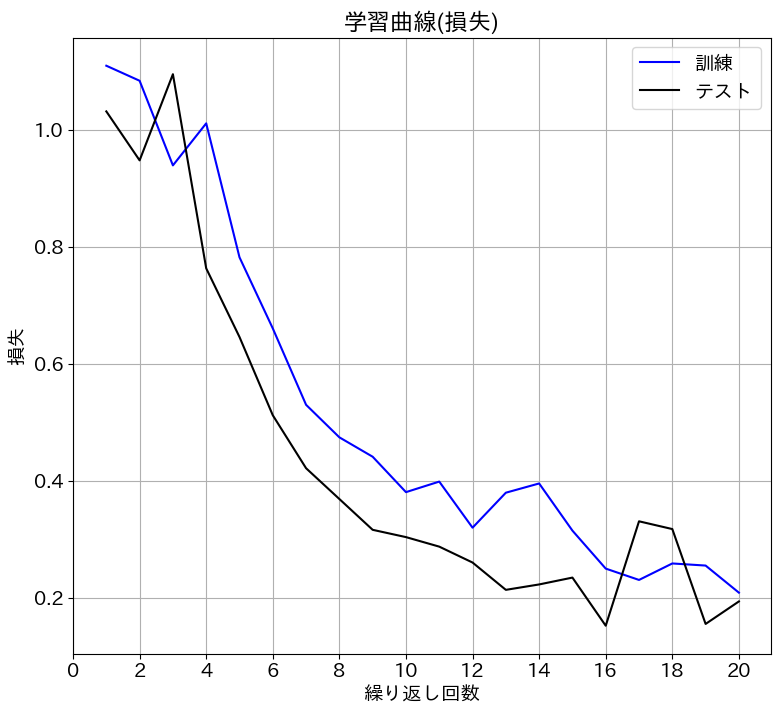

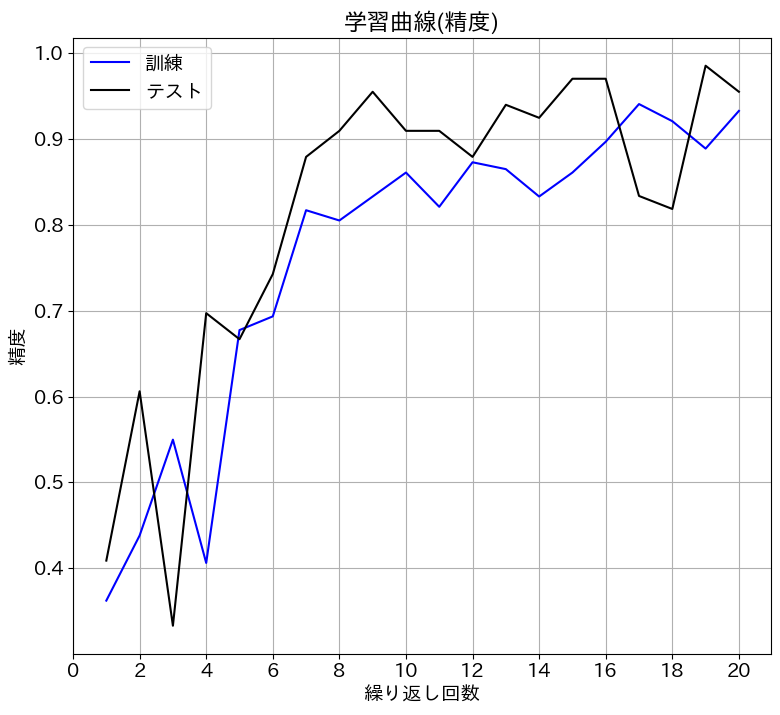

In [32]:
# 結果確認
evaluate_history(history)

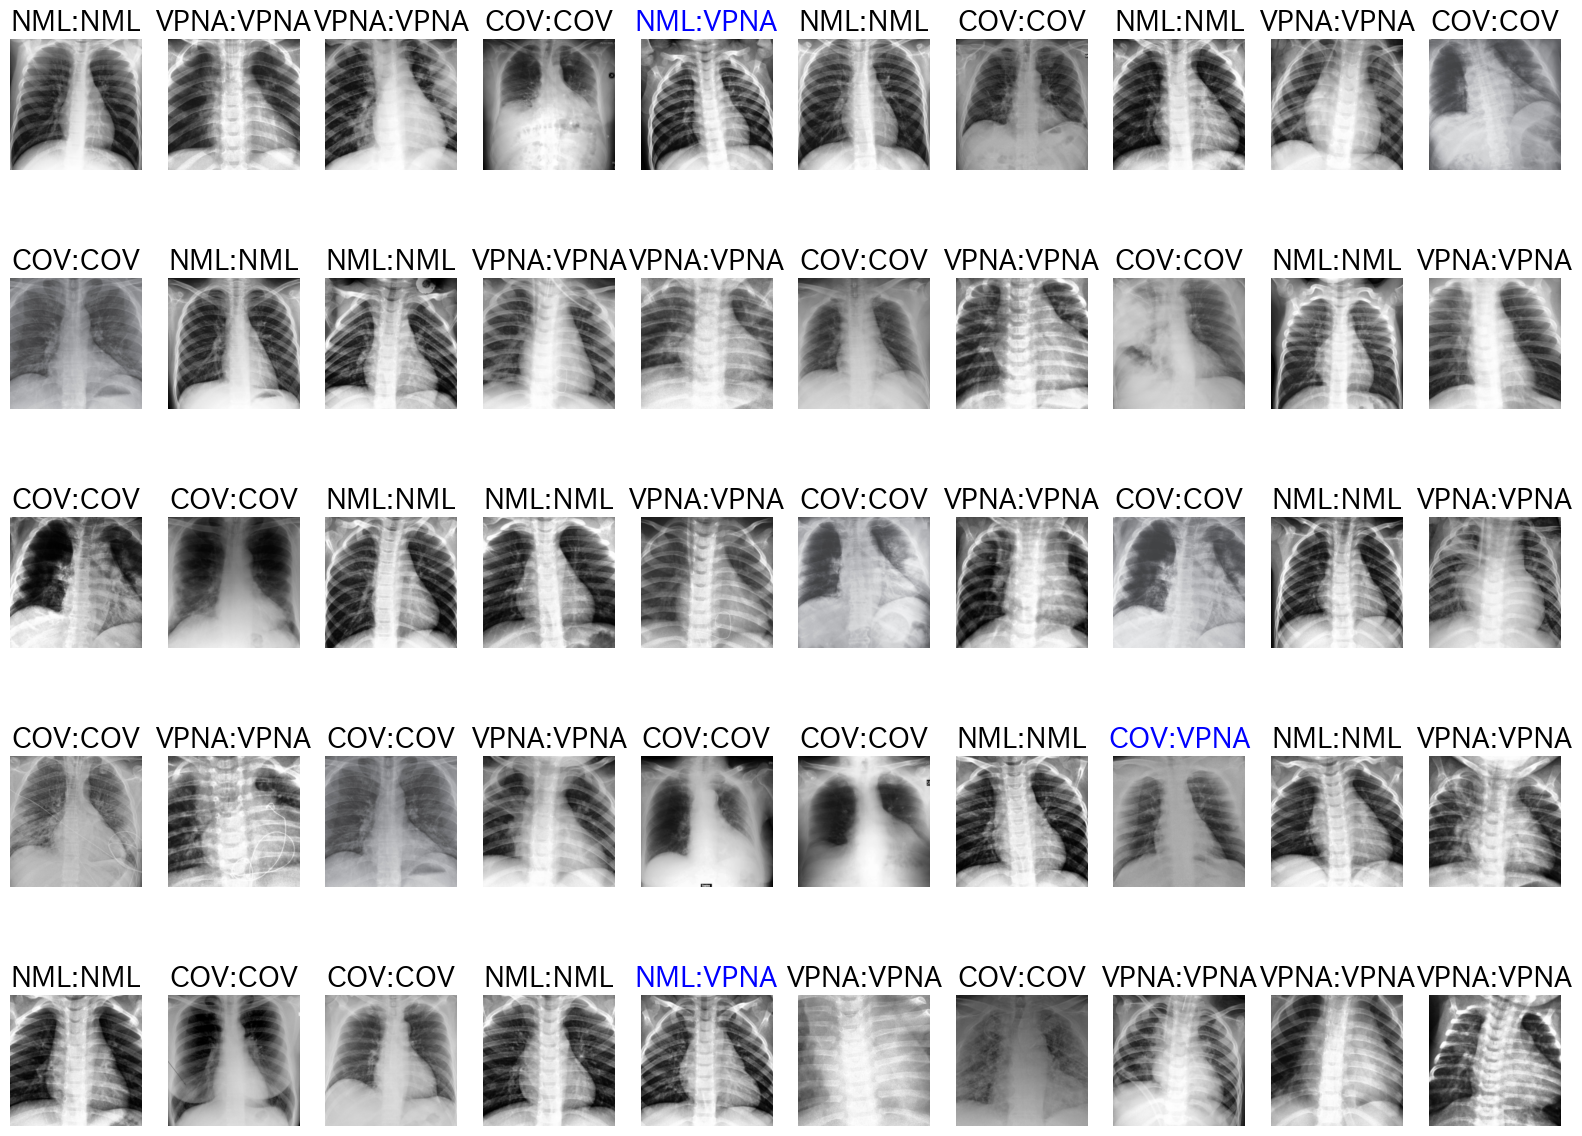

In [33]:
# 乱数初期化
torch_seed()

# 検証データへの結果表示
show_images_labels(test_loader2, classes, net, device)


## 転移学習版

In [26]:
# vgg19_bnをパラメータ付きで読み込む
from torchvision import models
net = models.vgg19_bn(pretrained = True)

# すべてのパラメータで勾配計算なしに
for param in net.parameters():
    param.requires_grad = False

# 乱数初期化
torch_seed()

# 最終ノードの出力を2に変更する
# このノードのみ勾配計算をすることになる
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 3)

# AdaptiveAvgPool2d関数の取り外し
net.avgpool = nn.Identity()

# GPUの利用
net = net.to(device)

# 学習率
lr = 0.001

# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
# パラメータ修正の対象を最終ノードに限定
optimizer = optim.SGD(net.classifier[6].parameters(),lr=lr,momentum=0.9)

# historyファイルも同時に初期化する
history = np.zeros((0, 5))

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


100%|██████████| 548M/548M [00:07<00:00, 76.3MB/s]


In [27]:
# 学習
num_epochs = 20
history = fit(net, optimizer, criterion, num_epochs,
          train_loader, test_loader, device, history)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[1/20],loss:1.11443 acc:0.34263 test_loss:1.0383360241398667 test_acc:0.40909


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[2/20],loss:1.09552 acc:0.43825 test_loss:0.9484448125868132 test_acc:0.54545


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[3/20],loss:1.00062 acc:0.50199 test_loss:1.2018201567909934 test_acc:0.33333


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[4/20],loss:1.06740 acc:0.41036 test_loss:0.8785846287553961 test_acc:0.60606


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[5/20],loss:0.95593 acc:0.50598 test_loss:0.7142916357878483 test_acc:0.69697


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[6/20],loss:0.76344 acc:0.64940 test_loss:0.6592820196440725 test_acc:0.72727


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[7/20],loss:0.78394 acc:0.64542 test_loss:0.9128761526310083 test_acc:0.46970


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[8/20],loss:0.76837 acc:0.65339 test_loss:0.6049729784329733 test_acc:0.80303


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[9/20],loss:0.80128 acc:0.64143 test_loss:0.5884436784368573 test_acc:0.77273


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[10/20],loss:0.71179 acc:0.69323 test_loss:0.5055669654499401 test_acc:0.83333


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[11/20],loss:0.64800 acc:0.72908 test_loss:0.506936411965977 test_acc:0.78788


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[12/20],loss:0.60513 acc:0.74502 test_loss:0.5272383879531514 test_acc:0.81818


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[13/20],loss:0.64906 acc:0.69721 test_loss:0.48433706254670117 test_acc:0.87879


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[14/20],loss:0.67251 acc:0.71713 test_loss:0.6030790534886447 test_acc:0.75758


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[15/20],loss:0.73358 acc:0.68127 test_loss:0.6112248807242422 test_acc:0.75758


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[16/20],loss:0.57374 acc:0.76494 test_loss:0.47832723277987854 test_acc:0.81818


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[17/20],loss:0.63658 acc:0.72908 test_loss:0.5582503080368042 test_acc:0.72727


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[18/20],loss:0.62850 acc:0.71713 test_loss:0.4419966665181247 test_acc:0.86364


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[19/20],loss:0.58054 acc:0.76096 test_loss:0.43801832379716815 test_acc:0.81818


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[20/20],loss:0.49546 acc:0.80478 test_loss:0.5603737253131289 test_acc:0.74242


In [30]:
num_epochs = 15
history = fit(net, optimizer, criterion, num_epochs,
          train_loader, test_loader, device, history)

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[6/20],loss:0.56960 acc:0.78884 test_loss:0.4606570312471101 test_acc:0.87879


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[7/20],loss:0.55950 acc:0.77689 test_loss:0.43297020323348767 test_acc:0.86364


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[8/20],loss:0.51996 acc:0.80080 test_loss:0.41811788533673144 test_acc:0.87879


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[9/20],loss:0.56539 acc:0.78486 test_loss:0.41314451351310266 test_acc:0.89394


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[10/20],loss:0.47655 acc:0.81673 test_loss:0.41300861763231683 test_acc:0.86364


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[11/20],loss:0.51028 acc:0.82470 test_loss:0.4103842251228564 test_acc:0.87879


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[12/20],loss:0.52885 acc:0.79681 test_loss:0.4055740607507301 test_acc:0.87879


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[13/20],loss:0.51670 acc:0.79283 test_loss:0.3841691965406591 test_acc:0.89394


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[14/20],loss:0.58913 acc:0.72908 test_loss:0.4256496519753427 test_acc:0.83333


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[15/20],loss:0.52035 acc:0.76892 test_loss:0.38678472285920923 test_acc:0.84848


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[16/20],loss:0.54228 acc:0.74104 test_loss:0.3706629845229062 test_acc:0.87879


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[17/20],loss:0.50791 acc:0.79681 test_loss:0.35588536072861066 test_acc:0.90909


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[18/20],loss:0.41243 acc:0.84861 test_loss:0.3603864908218384 test_acc:0.87879


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[19/20],loss:0.51879 acc:0.75697 test_loss:0.38144444877451117 test_acc:0.84848


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[20/20],loss:0.47258 acc:0.84064 test_loss:0.41857508795730997 test_acc:0.78788


初期状態: 損失: 1.03834 精度: 0.40909
最終状態: 損失: 0.56037 精度: 0.74242


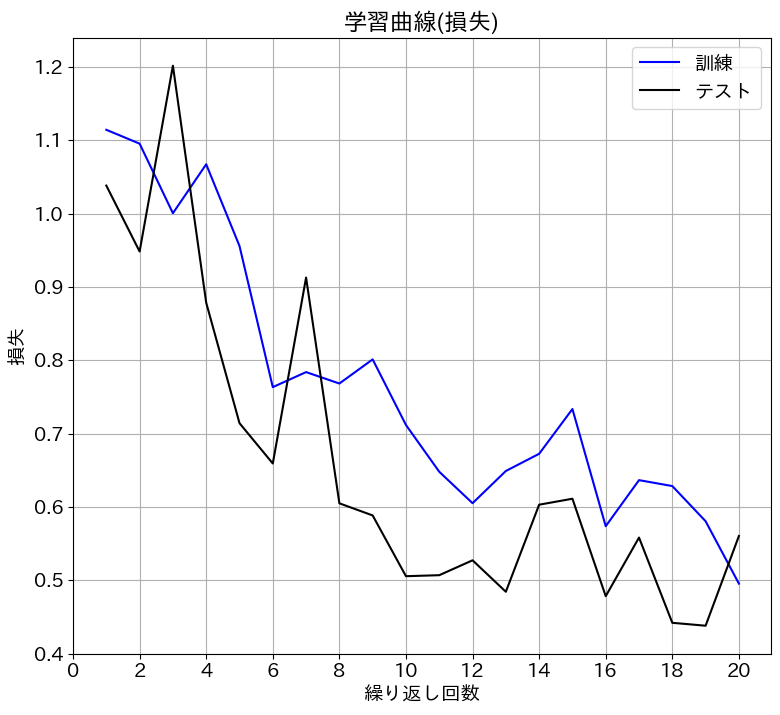

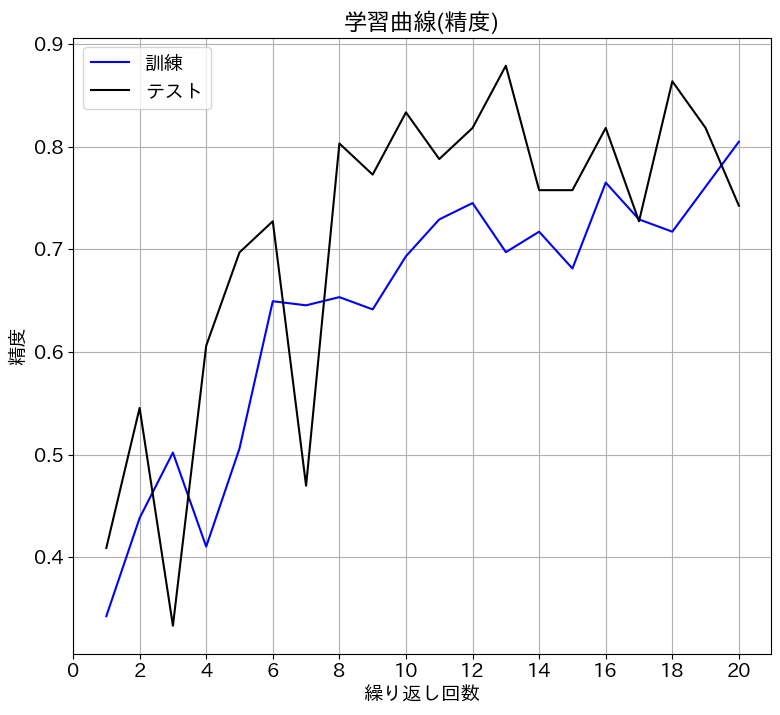

In [28]:
# 結果サマリー
evaluate_history(history)

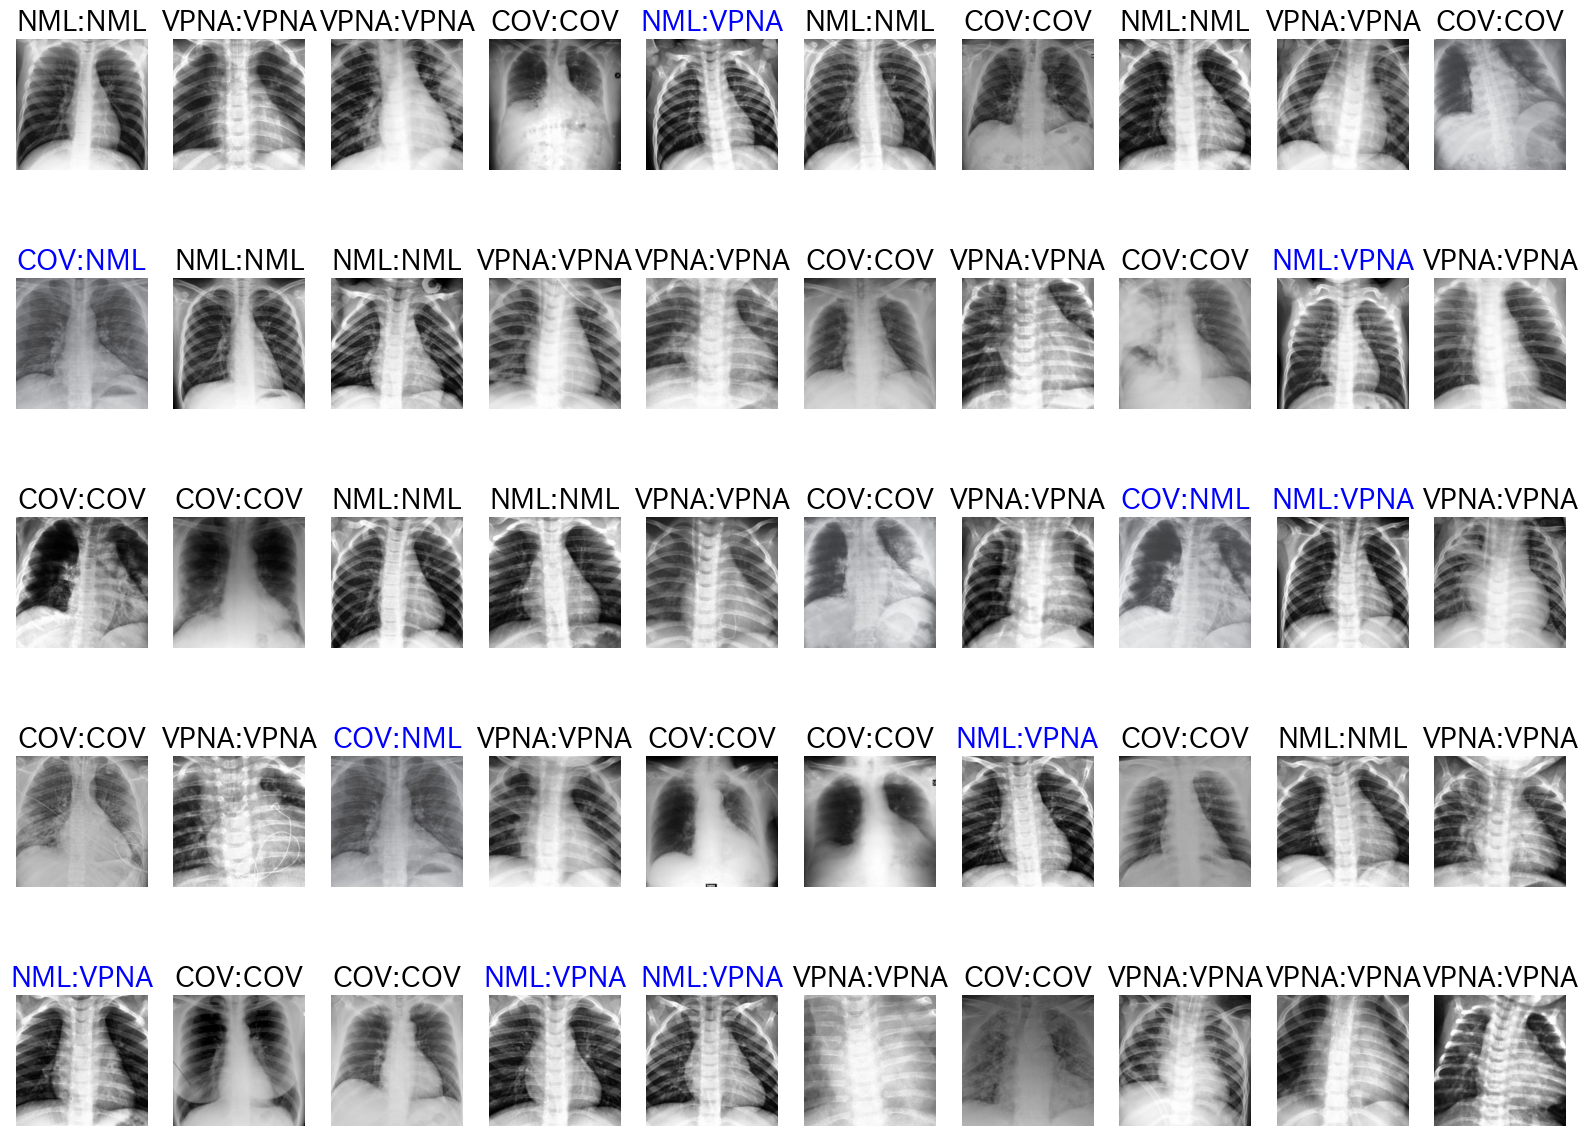

In [29]:
# 乱数初期化
torch_seed()

# テストデータへの結果表示
show_images_labels(test_loader2, classes, net, device)